# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [4]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam, SGD
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

# %matplotlib inline

# Set the image size.
img_height = 300
img_width = 300

/usr/lib64/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=9,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                clip_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=[2, 1, 0],
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = './models/belgas_relabelled_sgd_frozen_do_over/10_layers/best_redo.h5'
model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

W0808 17:12:40.497915 139769494435008 deprecation_wrapper.py:119] From /usr/lib64/python2.7/site-packages/keras/backend/tensorflow_backend.py:89: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 17:12:40.500808 139769494435008 deprecation_wrapper.py:119] From /usr/lib64/python2.7/site-packages/keras/backend/tensorflow_backend.py:92: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 17:12:40.523787 139769494435008 deprecation_wrapper.py:119] From /usr/lib64/python2.7/site-packages/keras/backend/tensorflow_backend.py:96: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 17:12:40.525988 139769494435008 deprecation_wrapper.py:119] From /usr/lib64/python2.7/site-packages/keras/backend/tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 17:12:40.541017

In [6]:
# import pandas as pd

# dir_path = '../datasets/images/'
# test_imgs = pd.read_csv('../datasets/belgas_relabelled.csv').frame
# test_paths = [dir_path + img for img in test_imgs]

In [19]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# # We'll only load one image in this example.

test_paths = []
for i in range(100):
    test_paths.append('../datasets/clips/game_frames/frame{}.jpg'.format(i))
    
for img_path in test_paths:
    orig_images.append(imread(img_path))
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = image.img_to_array(img) 
    input_images.append(img)
input_images = np.array(input_images)
y_pred = model.predict(input_images)

In [21]:
confidence_threshold = 0.5
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])
np.array(range(y_pred.shape[0]))[[np.array([y_pred_thresh[i].size > 0.5 for i in range(y_pred.shape[0])])]]

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.74  81.   211.42 169.49 286.94]]


array([ 0,  1,  2, 26, 44, 48, 49, 50, 51, 52, 54, 55])

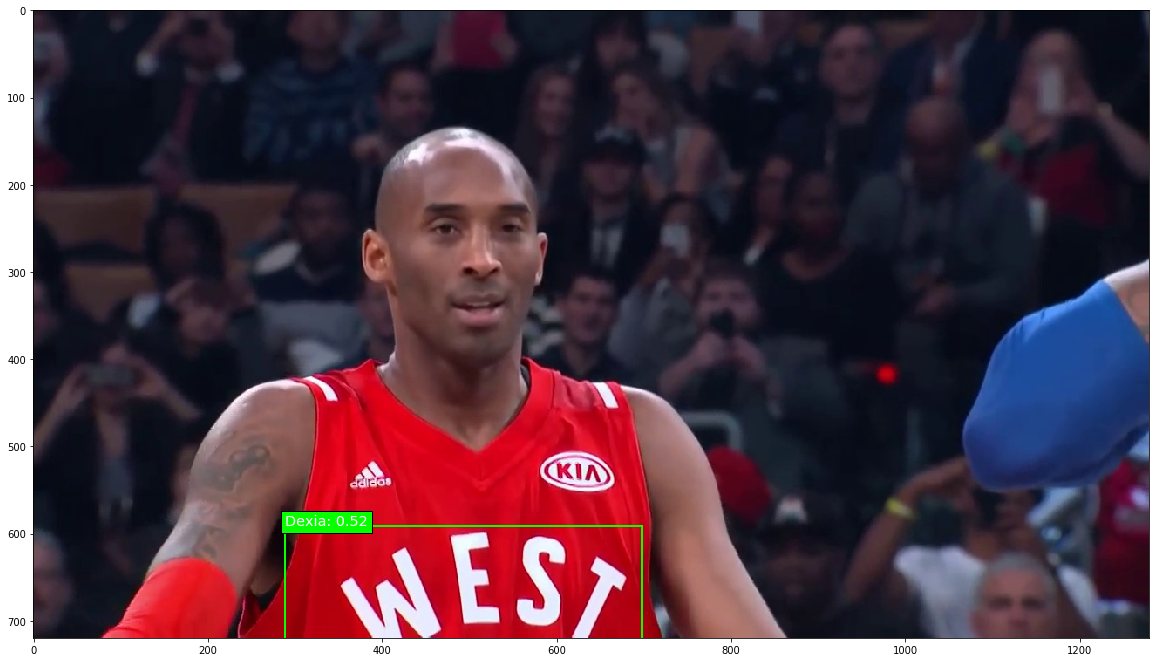

In [26]:
# Display the image and draw the predicted boxes onto it.
index = 55
# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()
classes = ['Adidas',
 'Base',
 'Citroen-text',
 'Dexia',
 'Kia',
 'Nike',
 'Puma',
 'Shell',
 'TNT',
 'Umbro']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[index])

current_axis = plt.gca()

for box in y_pred_thresh[index]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
images_dir = '../datasets/images'
labels_file_train = '../datasets/belgas_relabelled.csv'
labels_file_test = '../datasets/belgas_relabelled_test.csv'

classes = ['Adidas',
 'Base',
 'Citroen-text',
 'Dexia',
 'Kia',
 'Nike',
 'Puma',
 'Shell',
 'TNT',
 'Umbro'] # Just so we can print class names onto the image instead of IDs

dataset.parse_csv(images_dir,labels_file_test,['image_name','xmin','xmax','ymin','ymax','class_id'])

# TODO: Set the paths to the datasets here.

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=100,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)

In [ ]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

In [ ]:
confidence_threshold = 0.9
# Predict.

y_pred = model.predict(batch_images)
# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

high_conf_indices = np.array(range(y_pred.shape[0]))[[np.array([y_pred_thresh[i].size > 0 for i in range(y_pred.shape[0])])]]

In [ ]:
for i in high_conf_indices:
    # Display the image and draw the predicted boxes onto it.
    # Set the colors for the bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()

    plt.figure(figsize=(20,12))
    plt.imshow(batch_original_images[i])

    current_axis = plt.gca()

    for box in batch_original_labels[i]:
        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        label = '{}'.format(classes[int(box[0])])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

    for box in y_pred_thresh_inv[i]:
        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
        current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

    plt.savefig('examples/inference_test_{}.png'.format(i))